In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import os
import numpy as np

In [2]:
# 创建保存结果的文件夹
# Create a folder where the results are saved
result_dir = 'results/decision_tree_results'
os.makedirs(result_dir, exist_ok=True)

In [3]:
# 加载数据
# Load the data
file_path = 'data/train.csv'
data = pd.read_csv(file_path)

In [4]:
# 处理缺失值，用列的平均值填充
# Missing values are processed, populated with the average of the columns
data.fillna(data.mean(), inplace=True)

In [5]:
# 编码离散特征
# Encode discrete features
label_encoders = {}
for col in data.columns:
    if 'cat' in col:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

In [6]:
# 标准化数值特征
# Normalize numeric features
scaler = StandardScaler()
num_features = [col for col in data.columns if 'num' in col]
data[num_features] = scaler.fit_transform(data[num_features])

In [7]:
# 数据拆分为特征和目标变量
# Data is split into features and target variables
X = data.drop(columns=['id', 'target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 参数随机搜索
# Random parameter search
param_dist = {'max_depth': np.arange(1, 21), 'min_samples_split': np.arange(2, 10)}
random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_dist, n_iter=20, cv=5, scoring='roc_auc', n_jobs=-1)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   scoring='roc_auc')

In [9]:
# 获取最佳参数的决策树模型
# Decision tree model to get the best parameters
best_tree_model = random_search.best_estimator_
y_pred_best_tree = best_tree_model.predict_proba(X_test)[:, 1]
auc_best_tree = roc_auc_score(y_test, y_pred_best_tree)

In [10]:
# 保存训练好的模型
# Save the trained model
model_file = os.path.join(result_dir, 'decision_tree_model.pkl')
joblib.dump(best_tree_model, model_file)

['results/decision_tree_results\\decision_tree_model.pkl']

In [11]:
# 保存编码器和标准化器
# Save the trained model
scaler_file = os.path.join(result_dir, 'scaler.pkl')
encoder_file = os.path.join(result_dir, 'label_encoders.pkl')
joblib.dump(scaler, scaler_file)
joblib.dump(label_encoders, encoder_file)

['results/decision_tree_results\\label_encoders.pkl']

In [12]:
# 输出AUC得分
# Output AUC score
print(f'最佳决策树模型的 AUC: {auc_best_tree}')

最佳决策树模型的 AUC: 0.8791451144972418


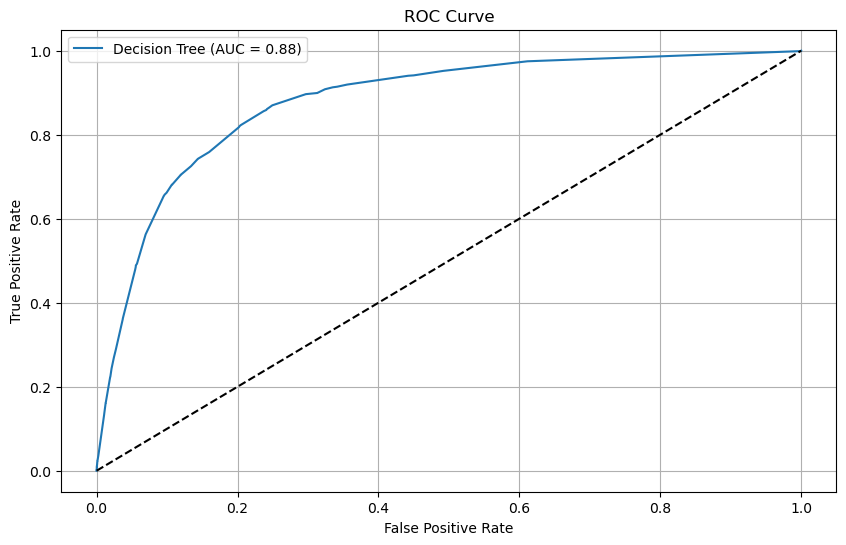

In [14]:
# 生成并保存ROC曲线
# Generate and save ROC curves
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_best_tree)

plt.figure(figsize=(10, 6))
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_best_tree:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
roc_curve_file = os.path.join(result_dir, 'roc_curve_tree.png')
plt.savefig(roc_curve_file)
plt.show()

In [15]:
# 计算混淆矩阵
# Calculate the confusion matrix
cm_tree = confusion_matrix(y_test, best_tree_model.predict(X_test))

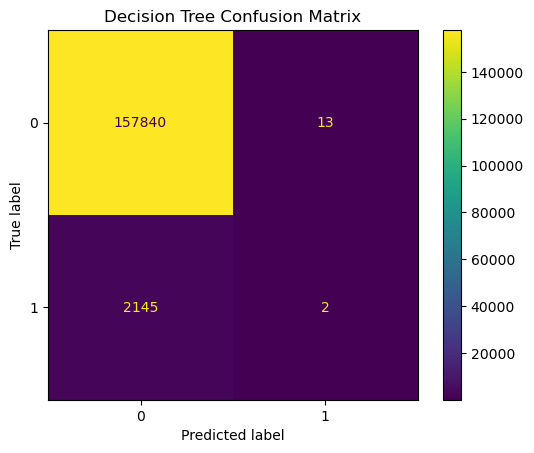

In [16]:
# 显示并保存混淆矩阵
# Display and save the confusion matrix
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree)
disp_tree.plot()
plt.title('Decision Tree Confusion Matrix')
confusion_matrix_file_tree = os.path.join(result_dir, 'confusion_matrix_tree.png')
plt.savefig(confusion_matrix_file_tree)
plt.show()

In [17]:
# 保存测试集预测结果到CSV文件
# Save the prediction results of the test set to a CSV file
test_results_tree = pd.DataFrame({
    'id': data.iloc[X_test.index]['id'],
    'y_pred_tree': y_pred_best_tree,
    'true_label': y_test
})
test_results_tree.to_csv(os.path.join(result_dir, 'test_predictions_tree.csv'), index=False)
print(f"决策树模型预测结果已保存到 {os.path.join(result_dir, 'test_predictions_tree.csv')}")

决策树模型预测结果已保存到 results/decision_tree_results\test_predictions_tree.csv
